# Simple production forecast without making use of weather data

In [1]:
#import packages & libraries
import numpy as np
from neuralprophet import NeuralProphet
import pandas as pd
%matplotlib inline
import plotly.express as px

In [2]:
#initialize plotly
import plotly.io as pio

pio.renderers.default = 'colab'

## Exploratory Data Analysis

In [3]:
#read dataset
df = pd.read_csv('./../datasets/prod-region.csv', sep=';')
df.head(1000)

WARNING - (py.warnings._showwarnmsg) - D:\anaconda3\envs\v-env\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning:

Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.




,Horodate,Région,Code région,Plage de puissance injection,Filière de production,Nb points injection,Total énergie injectée (Wh),Courbe Moyenne n°1 (Wh),Indice représentativité Courbe n°1 (%),Courbe Moyenne n°2 (Wh),Indice représentativité Courbe n°2 (%),Courbe Moyenne n°1 + n°2 (Wh),Indice représentativité Courbe n°1 + n°2 (%),Jour max du mois (0/1),Semaine max du mois (0/1)
0,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P3 : ]9 - 100] kW,F5 : Solaire,6625,0.0,NaN,S,NaN,S,NaN,S,S,S
1,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P6 : ]1000 - 12000] kW,F5 : Solaire,272,0.0,0.0,49,0.0,50,0.0,99,0,0
2,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P2 : ]3 - 9] kW,F5 : Solaire,18491,0.0,NaN,S,NaN,S,NaN,S,S,S
3,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P4 : ]100 - 250] kW,F5 : Solaire,1379,0.0,0.0,49,0.0,50,0.0,100,0,0
4,2021-12-31T23:30:00+01:00,Nouvelle Aquitaine,75,P7 : > 12000 kW,F5 : Solaire,14,0.0,0.0,50,0.0,50,0.0,100,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P3 : ]9 - 100] kW,F5 : Solaire,6608,7712994.0,NaN,S,NaN,S,NaN,S,S,S
996,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P1 : ]0 - 3] kW,F5 : Solaire,42924,1273208.0,NaN,S,NaN,S,NaN,S,S,S
997,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P4 : ]100 - 250] kW,F5 : Solaire,1378,2583480.0,2130.0,49,1529.0,50,1828.0,100,0,0
998,2021-12-29T09:30:00+01:00,Nouvelle Aquitaine,75,P7 : > 12000 kW,F5 : Solaire,14,2719000.0,268166.0,50,120261.0,50,194214.0,100,0,0


In [4]:
#reduce information
df.drop(['Région', 'Code région', 'Plage de puissance injection', 'Filière de production', 'Nb points injection',
         'Total énergie injectée (Wh)', 'Courbe Moyenne n°1 (Wh)', 'Indice représentativité Courbe n°1 (%)',
         'Courbe Moyenne n°2 (Wh)', 'Indice représentativité Courbe n°2 (%)',
         'Indice représentativité Courbe n°1 + n°2 (%)', 'Jour max du mois (0/1)', 'Semaine max du mois (0/1)'],
        axis='columns', inplace=True)
df.dropna(inplace=True)
df['Horodate'] = pd.to_datetime(df['Horodate'].values, utc=True)
df['Horodate'] = df['Horodate'].dt.tz_localize(None)
df = df.loc[df['Horodate'] > '2020-06-01']
df.head(100)

,Horodate,Courbe Moyenne n°1 + n°2 (Wh)
1,2021-12-31 22:30:00,0.0
3,2021-12-31 22:30:00,0.0
4,2021-12-31 22:30:00,0.0
5,2021-12-31 22:30:00,0.0
10,2021-12-31 22:00:00,0.0
...,...,...
230,2021-12-31 08:30:00,29789.0
231,2021-12-31 08:30:00,392695.0
234,2021-12-31 08:00:00,6562.0
236,2021-12-31 08:00:00,398285.0


In [5]:
df = df.groupby('Horodate').sum().iloc[::-1]
df = df.reset_index()
df.head(1000)

,Horodate,Courbe Moyenne n°1 + n°2 (Wh)
0,2021-12-31 22:30:00,0.0
1,2021-12-31 22:00:00,0.0
2,2021-12-31 21:30:00,0.0
3,2021-12-31 21:00:00,1.0
4,2021-12-31 20:30:00,0.0
...,...,...
995,2021-12-11 02:00:00,0.0
996,2021-12-11 01:30:00,0.0
997,2021-12-11 01:00:00,0.0
998,2021-12-11 00:30:00,0.0


In [6]:
#get info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27772 entries, 0 to 27771
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Horodate                       27772 non-null  datetime64[ns]
 1   Courbe Moyenne n°1 + n°2 (Wh)  27772 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 434.1 KB


In [7]:
#get statistics
df.describe()

,Courbe Moyenne n°1 + n°2 (Wh)
count,2.777200e+04
mean,1.520931e+06
std,2.244601e+06
min,0.000000e+00
25%,0.000000e+00
50%,2.158000e+04
75%,2.637814e+06
max,8.723515e+06


## Data Visualization

In [27]:
#area graph (Date Vs Price)
px.scatter(df,
           x='Horodate',
           y='Courbe Moyenne n°1 + n°2 (Wh)')

In [28]:
#violin plot
px.violin(df,
          y='Courbe Moyenne n°1 + n°2 (Wh)')

## Data Preparation

In [29]:
#get columns' names
df.columns

Index(['Horodate', 'Courbe Moyenne n°1 + n°2 (Wh)'], dtype='object')

In [30]:
#rename columns
prophet_df = df.rename(columns={'Horodate': 'ds',
                                'Courbe Moyenne n°1 + n°2 (Wh)': 'y'})

#check
prophet_df.columns

Index(['ds', 'y'], dtype='object')

In [33]:
MAX_DATE = prophet_df['ds'].max()
MAX_DATE

Timestamp('2021-12-31 22:30:00')

## Train Model

In [13]:
model = NeuralProphet(n_forecasts=365,
                      n_lags=30,
                      yearly_seasonality=True,
                      #weekly_seasonality=True,
                      daily_seasonality=True,
                      batch_size=64,
                      epochs=200,
                      learning_rate=0.03)

model.fit(prophet_df, freq='30min')

INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.935% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.forecaster.__handle_missing_data) - 17 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 17 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
Epoch[200/200]: 100%|██████████| 200/200 [18:12<00:00,  5.46s/it, SmoothL1Loss=0.0118, MAE=7.18e+5, RMSE=1.01e+6, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.796997,7.938126e+06,9.846451e+06,0.0
1,0.416468,5.164449e+06,6.423212e+06,0.0
2,0.191270,3.300763e+06,4.088572e+06,0.0
3,0.077155,2.071409e+06,2.552937e+06,0.0
4,0.034357,1.374171e+06,1.708358e+06,0.0
...,...,...,...,...
195,0.011855,7.176072e+05,1.008596e+06,0.0
196,0.011854,7.174782e+05,1.008450e+06,0.0
197,0.011850,7.179906e+05,1.008348e+06,0.0
198,0.011850,7.174910e+05,1.008402e+06,0.0


In [40]:
model = NeuralProphet(daily_seasonality=True,
                      yearly_seasonality=True,
                      batch_size=64,
                      epochs=200,
                      learning_rate=0.03)
model.fit(prophet_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.935% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as 30T
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
Epoch[200/200]: 100%|██████████| 200/200 [02:22<00:00,  1.40it/s, SmoothL1Loss=0.0146, MAE=8.63e+5, RMSE=1.11e+6, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.755660,7.634306e+06,9.472259e+06,0.0
1,0.502672,5.792025e+06,7.224305e+06,0.0
2,0.266088,3.914837e+06,4.935552e+06,0.0
3,0.099916,2.262940e+06,2.896042e+06,0.0
4,0.031136,1.268234e+06,1.611142e+06,0.0
...,...,...,...,...
195,0.014578,8.640155e+05,1.113601e+06,0.0
196,0.014574,8.625963e+05,1.113510e+06,0.0
197,0.014565,8.632350e+05,1.112555e+06,0.0
198,0.014564,8.632700e+05,1.112760e+06,0.0


In [41]:
future = model.make_future_dataframe(prophet_df, periods=365*48)
forecast = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency -30T corresponds to 99.935% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 30T is different than major frequency -30T
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.994% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.994% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30T


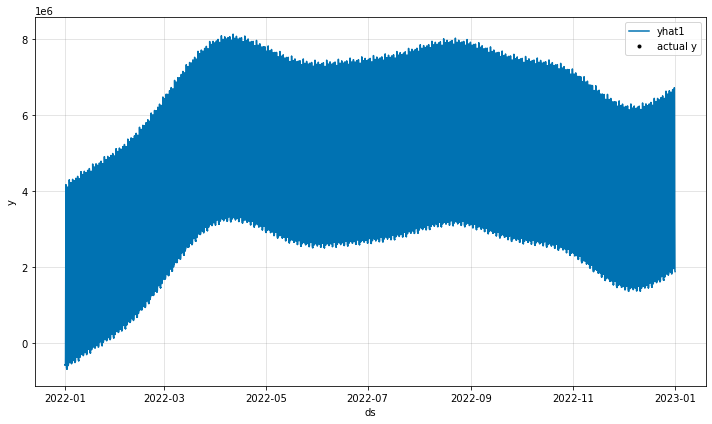

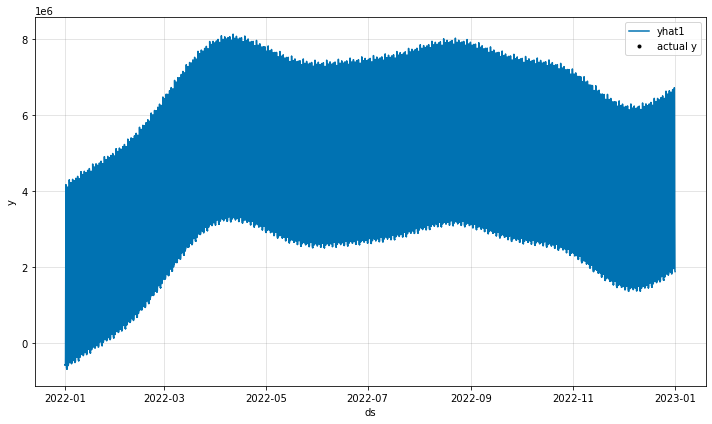

In [42]:
model.plot(forecast)

In [20]:
future = model.make_future_dataframe(prophet_df, periods=365)

#predict
forecast = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency -30T corresponds to 99.935% of the data.
WARNING - (NP.df_utils._infer_frequency) - Defined frequency 30min is different than major frequency -30T
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.494% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.df_utils._infer_frequency) - Major frequency 30T corresponds to 99.494% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.forecaster.__handle_missing_data) - 27759 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - Detected y to have more NaN values than n_forecast can predict. Dropped 0 rows at end.
WARNING - (py.warnings._showwarnmsg) - D:\anaconda3\envs\v-env\lib\site-packages\neuralprophet\forecaster.py:2284: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `f

In [26]:
future.iloc[::-1]

,ds,y
394,2022-01-08 13:00:00,NaN
393,2022-01-08 12:30:00,NaN
392,2022-01-08 12:00:00,NaN
391,2022-01-08 11:30:00,NaN
390,2022-01-08 11:00:00,NaN
...,...,...
4,2020-06-01 02:30:00,0.0
3,2020-06-01 02:00:00,0.0
2,2020-06-01 01:30:00,0.0
1,2020-06-01 01:00:00,0.0


WARNING - (NP.forecaster.plot) - Too few forecasts to plot a line per forecast step.Plotting a line per forecast origin instead.


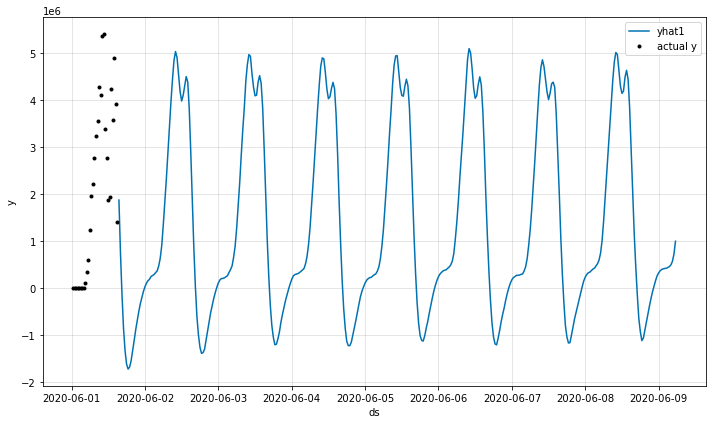

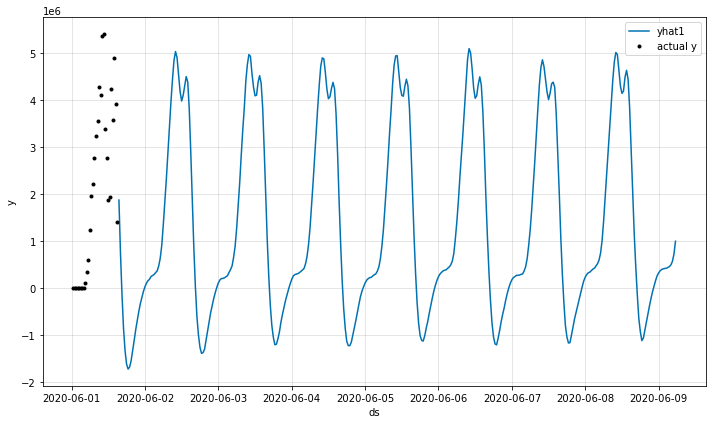

In [22]:
model.plot(forecast)